<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Natural Language Processing

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Setup

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [4]:
SEMENTE = 2008193

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

FILTROS = 32
NUCLEO_TAMANHO = 32
PREENCHIMENTO = 'same'

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

DIRETORIO_TB = 'tb_nlp'

### Funções

In [5]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-29 01:30:20--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-29 01:30:20 (50.2 MB/s) - ‘funcoes.py’ saved [5196/5196]



In [6]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

In [7]:
def avaliar_modelo(previsao, validacao):
    print(classification_report(validacao, previsao))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, cmap='summer_r')
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

### Limpar diretorio TensorBoard

In [8]:
# # Apagar diretórios não-vazios
# import shutil
# shutil.rmtree(DIRETORIO_TB)

## Dados

Dados originalmente da competição **Natural Language Processing with Disaster Tweets** no Kaggle. (Em andamento em 27.01.2023.)

https://www.kaggle.com/c/nlp-getting-started

In [9]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-01-29 01:30:21--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.198.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-01-29 01:30:21 (115 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [10]:
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Embaralhar dados de treino (frac=1 = 100% dos dados)
df_treino = df_treino.sample(frac=1, random_state=SEMENTE)

In [11]:
df_treino.head()

,id,keyword,location,text,target
2299,3299,demolish,NYHC,If you think going to demolish Drake's house o...,1
3704,5269,fear,Carregado,I didn`t want to hurt you but the fear drove m...,0
3468,4961,explosion,New York,New Explosion-proof Tempered Glass Screen Prot...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
3634,5183,fatalities,jersey,mortal kombat fatalities are so gross but inte...,0


In [12]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 2299 to 4895
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


In [13]:
df_treino['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Separar dados para validação

In [14]:
X = df_treino['text']
y = df_treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Converter texto em números

In [23]:
limite_dicionario = 10000

media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
# maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

tamanho_texto = media_palavras_por_texto

### Vetorização (Vectorization)

In [24]:
vetorizador = TextVectorization(max_tokens=limite_dicionario,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [25]:
vetorizador.adapt(X_train)

In [26]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

@AmuMumuX lava you.?? quit actin up


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  403,   12, 9383,    1,   28,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [27]:
vocabulario = vetorizador.get_vocabulary()

In [28]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pacic', 'p45perez', 'oyster', 'oworoshoki', 'ownership'])

### Incorporação (Embedding)

In [29]:
incorporador = Embedding(input_dim=limite_dicionario,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [30]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

During the 1960s the oryx a symbol of the Arabian Peninsula were annihilated by hunters. 
http://t.co/yangEQBUQW http://t.co/jQ2eH5KGLt


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01126883, -0.01860626, -0.03767691, ..., -0.03371356,
          0.02714988, -0.02853748],
        [-0.00284929,  0.00245554, -0.0008914 , ..., -0.02923987,
         -0.03458171,  0.03843197],
        [-0.04466586,  0.04895597, -0.02620449, ..., -0.00575123,
          0.02681543, -0.03280537],
        ...,
        [-0.02728102,  0.02599322,  0.01492783, ...,  0.02723074,
         -0.03838317,  0.02867464],
        [ 0.03447275, -0.01131971,  0.02350405, ..., -0.01256441,
          0.02771742, -0.00159783],
        [-0.01826912, -0.02337061,  0.00778027, ...,  0.0061904 ,
         -0.02849001, -0.0441361 ]]], dtype=float32)>

## Experimentos

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TFHub Universal Sentence Encoder
* Model 7: Same as model 6 but using 10% of data

In [31]:
modelos = [None] * 8
avaliacoes = [None] * 8
previsoes = [None] * 8
relatorios = [None] * 8
historicos = [None] * 8

### Modelo 0: Naive Bayes with TF-IDF encoder (baseline)

In [32]:
modelos[0] = Pipeline([('tdidf', TfidfVectorizer()),
                       ('clf', MultinomialNB())]) # clf = classifier

modelos[0].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [33]:
avaliacoes[0] = modelos[0].score(X_test, y_test)
avaliacoes[0]

0.8083989501312336

In [34]:
previsoes[0] = modelos[0].predict(X_test)
previsoes[0][:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       433
           1       0.88      0.64      0.74       329

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.80       762



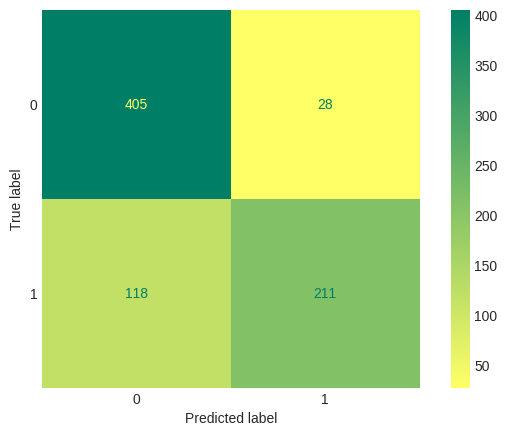

In [35]:
relatorios[0] = avaliar_modelo(previsoes[0], y_test)

In [36]:
relatorios[0]

{'acuracia': 0.8083989501312336,
 'precisao': 0.821209966257038,
 'revocacao': 0.8083989501312336,
 'pontuacao-f1': 0.8022381673606139}

### Modelo 1: Feed-forward neural network (dense model)

In [37]:
modelo_nome = 'modelo_1_dense'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)
camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[1] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[1].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[1] = modelos[1].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.6136 - accuracy: 0.6925 - val_loss: 0.5191 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4457 - accuracy: 0.8175 - val_loss: 0.4394 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3516 - accuracy: 0.8571 - val_loss: 0.4195 - val_accuracy: 0.8176
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2879 - accuracy: 0.8905 - val_loss: 0.4253 - val_accuracy: 0.8202
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2418 - accuracy: 0.9075 - val_loss: 0.4280 - val_accuracy: 0.8071


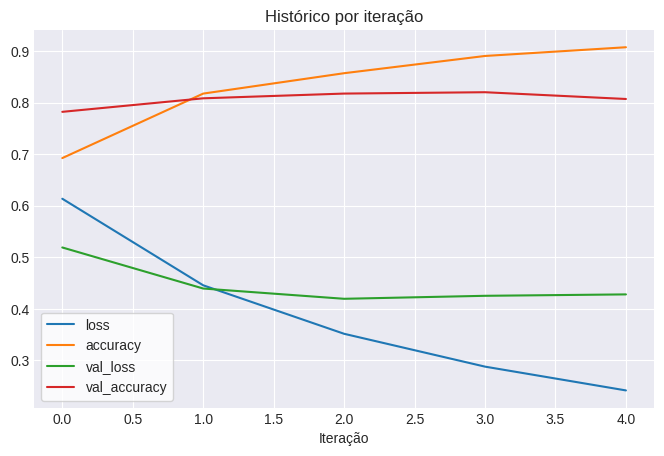

In [38]:
grafico_historico_por_iteracao(historicos[1])

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       433
           1       0.79      0.75      0.77       329

    accuracy                           0.81       762
   macro avg       0.80      0.80      0.80       762
weighted avg       0.81      0.81      0.81       762



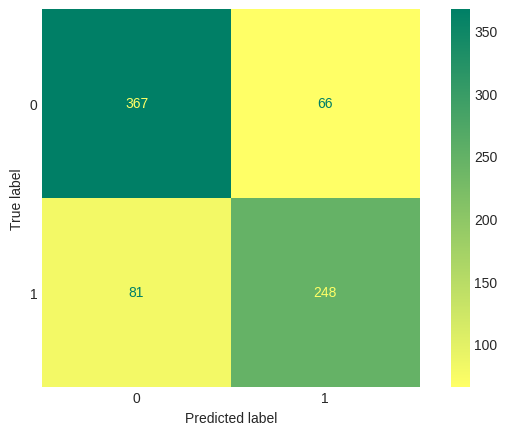

In [39]:
avaliacoes[1] = modelos[1].evaluate(X_test, y_test)
previsoes[1] = tf.squeeze(tf.round(modelos[1].predict(X_test)))
relatorios[1] = avaliar_modelo(previsoes[1], y_test)

In [40]:
relatorios[1]

{'acuracia': 0.8070866141732284,
 'precisao': 0.806508119854843,
 'revocacao': 0.8070866141732284,
 'pontuacao-f1': 0.8064787399851225}

### Modelo 2: LSTM model (RNN)

In [41]:
modelo_nome = 'modelo_2_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas) # Para empilhar camadas recorrentes é necessário return_sequences=True
camadas = LSTM(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[2] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[2].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[2] = modelos[2].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 10s 35ms/step - loss: 0.2242 - accuracy: 0.9172 - val_loss: 0.4611 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1581 - accuracy: 0.9435 - val_loss: 0.5195 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 6s 26ms/step - loss: 0.1265 - accuracy: 0.9549 - val_loss: 0.6479 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.1077 - accuracy: 0.9599 - val_loss: 0.5850 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0888 - accuracy: 0.9677 - val_loss: 0.7402 - val_accuracy: 0.7677


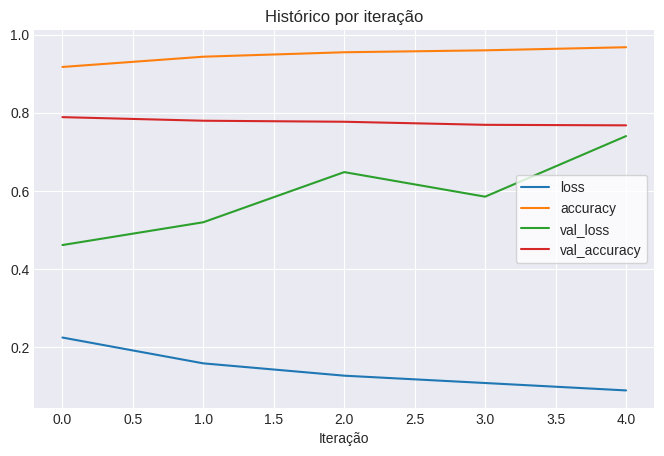

In [42]:
grafico_historico_por_iteracao(historicos[2])

24/24 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       433
           1       0.73      0.73      0.73       329

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



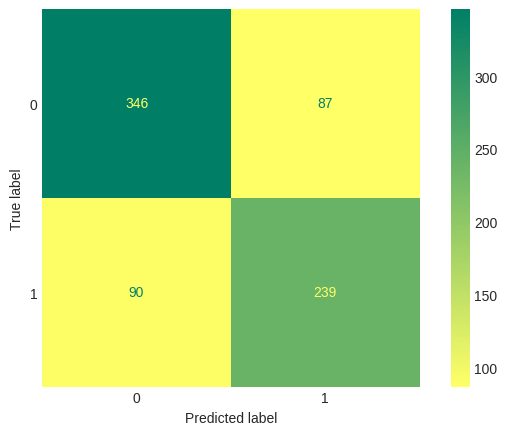

In [43]:
avaliacoes[2] = modelos[2].evaluate(X_test, y_test)
previsoes[2] = tf.squeeze(tf.round(modelos[2].predict(X_test)))
relatorios[2] = avaliar_modelo(previsoes[2], y_test)

In [44]:
relatorios[2]

{'acuracia': 0.7677165354330708,
 'precisao': 0.7674785466641908,
 'revocacao': 0.7677165354330708,
 'pontuacao-f1': 0.7675855381612642}

### Modelo 3: GRU model (RNN)

In [45]:
modelo_nome = 'modelo_3_gru'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = GRU(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas)
camadas = GRU(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camda_saida')(camadas)

modelos[3] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[3].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[3] = modelos[3].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.1558 - accuracy: 0.9406 - val_loss: 0.6849 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0864 - accuracy: 0.9693 - val_loss: 0.8348 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0744 - accuracy: 0.9723 - val_loss: 0.9612 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0634 - accuracy: 0.9746 - val_loss: 0.9375 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0532 - accuracy: 0.9758 - val_loss: 1.0934 - val_accuracy: 0.7690


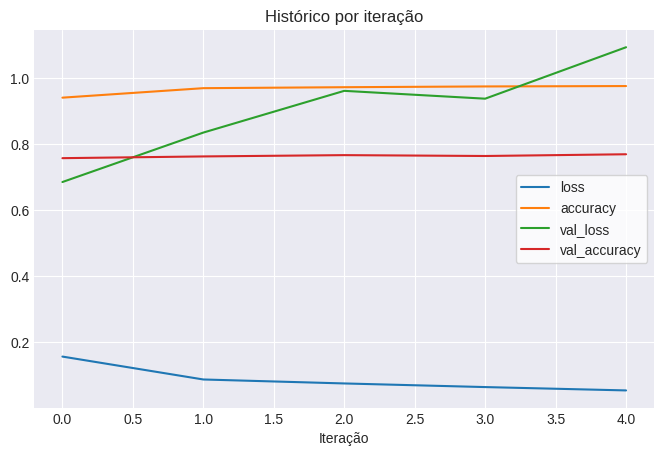

In [46]:
grafico_historico_por_iteracao(historicos[3])

24/24 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       433
           1       0.74      0.72      0.73       329

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



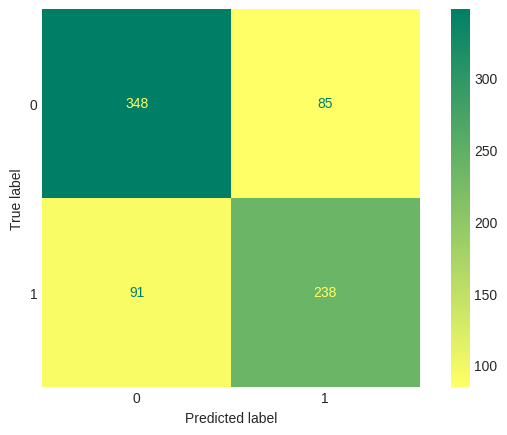

In [47]:
avaliacoes[3] = modelos[3].evaluate(X_test, y_test)
previsoes[3] = tf.squeeze(tf.round(modelos[3].predict(X_test)))
relatorios[3] = avaliar_modelo(previsoes[3], y_test)

In [48]:
relatorios[3]

{'acuracia': 0.7690288713910761,
 'precisao': 0.7685889611478699,
 'revocacao': 0.7690288713910761,
 'pontuacao-f1': 0.7687607462417791}

### Modelo 4: Bidirectional LSTM (RNN)

In [49]:
modelo_nome = 'modelo_4_bidirectional_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True))(camadas)
camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN))(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[4] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[4].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[4] = modelos[4].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.1057 - accuracy: 0.9673 - val_loss: 0.8925 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0523 - accuracy: 0.9788 - val_loss: 1.0763 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0478 - accuracy: 0.9785 - val_loss: 1.2837 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0423 - accuracy: 0.9783 - val_loss: 1.3608 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0412 - accuracy: 0.9790 - val_loss: 1.1210 - val_accuracy: 0.7717


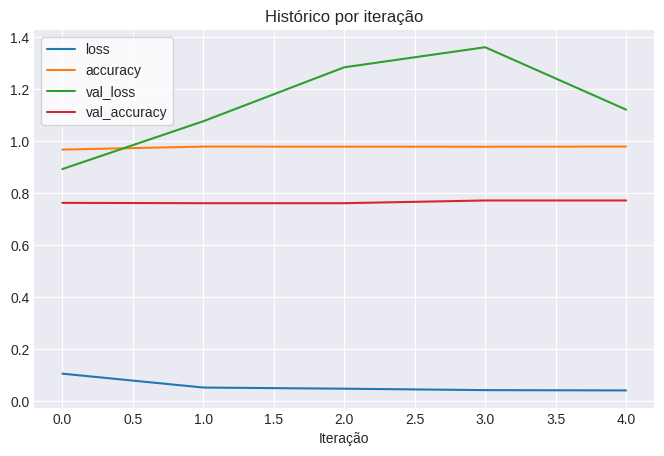

In [50]:
grafico_historico_por_iteracao(historicos[4])

24/24 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       433
           1       0.74      0.72      0.73       329

    accuracy                           0.77       762
   macro avg       0.77      0.77      0.77       762
weighted avg       0.77      0.77      0.77       762



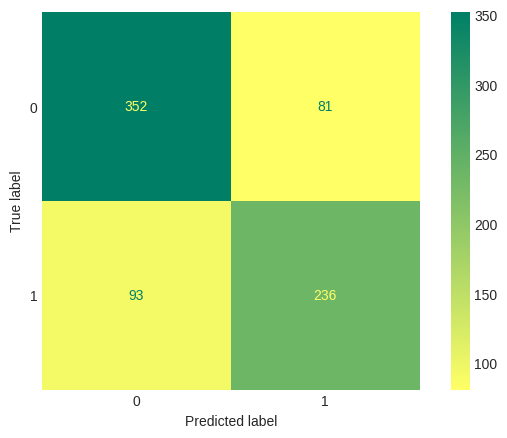

In [51]:
avaliacoes[4] = modelos[4].evaluate(X_test, y_test)
previsoes[4] = tf.squeeze(tf.round(modelos[4].predict(X_test)))
relatorios[4] = avaliar_modelo(previsoes[4], y_test)

In [52]:
relatorios[4]

{'acuracia': 0.7716535433070866,
 'precisao': 0.7709207599891825,
 'revocacao': 0.7716535433070866,
 'pontuacao-f1': 0.7710931325302075}

### Modelo 5: 1D Convolutional Neural Network

In [53]:
modelo_nome = 'modelo_5_1d_cnn'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,  # Quantidade de palavras processadas por vez.
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[5] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[5].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[5] = modelos[5].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 9s 39ms/step - loss: 0.0965 - accuracy: 0.9707 - val_loss: 0.9117 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0640 - accuracy: 0.9743 - val_loss: 1.0095 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0558 - accuracy: 0.9772 - val_loss: 1.0805 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0535 - accuracy: 0.9755 - val_loss: 1.1155 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0477 - accuracy: 0.9778 - val_loss: 1.1517 - val_accuracy: 0.7677


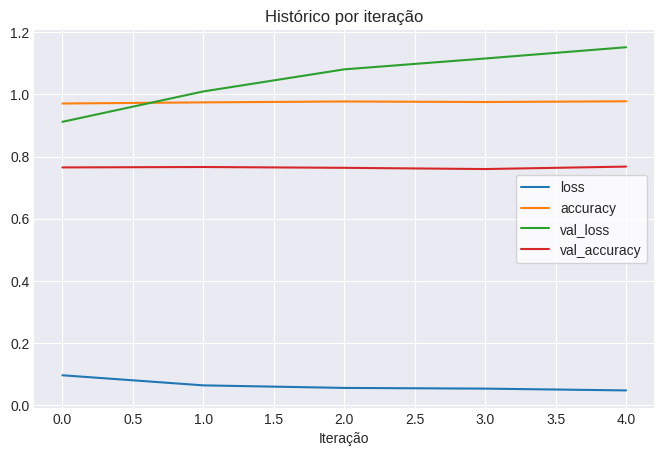

In [54]:
grafico_historico_por_iteracao(historicos[5])

24/24 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       433
           1       0.74      0.71      0.73       329

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



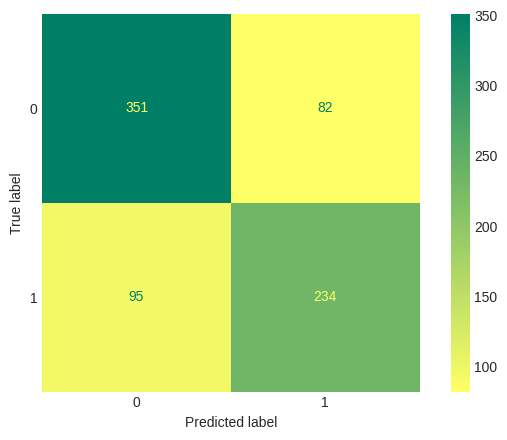

In [55]:
avaliacoes[5] = modelos[5].evaluate(X_test, y_test)
previsoes[5] = tf.squeeze(tf.round(modelos[5].predict(X_test)))
relatorios[5] = avaliar_modelo(previsoes[5], y_test)

In [56]:
relatorios[5]

{'acuracia': 0.7677165354330708,
 'precisao': 0.766923412827356,
 'revocacao': 0.7677165354330708,
 'pontuacao-f1': 0.7670933763647033}

### Modelo 6: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [57]:
modelo_nome = 'modelo_6_tfhub_use'

modelos[6] = Sequential(name=modelo_nome)

modelos[6].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                              trainable=False,
                              input_shape=[], # USE aceita textos de tamanho variável.
                              dtype=ENTRADA_TIPO,
                              name='camada_use'))

modelos[6].add(Dense(64, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[6].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[6].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[6] = modelos[6].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5089 - accuracy: 0.7835 - val_loss: 0.4497 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4156 - accuracy: 0.8149 - val_loss: 0.4373 - val_accuracy: 0.7992
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4028 - accuracy: 0.8227 - val_loss: 0.4315 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3941 - accuracy: 0.8251 - val_loss: 0.4273 - val_accuracy: 0.8031
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3879 - accuracy: 0.8288 - val_loss: 0.4266 - val_accuracy: 0.8005


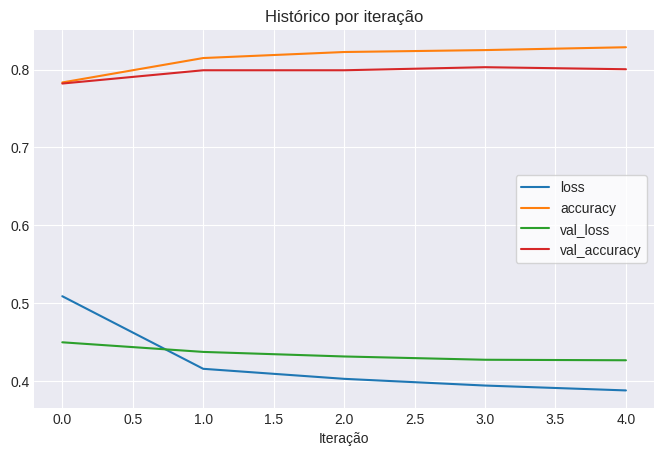

In [58]:
grafico_historico_por_iteracao(historicos[6])

24/24 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       433
           1       0.79      0.73      0.76       329

    accuracy                           0.80       762
   macro avg       0.80      0.79      0.79       762
weighted avg       0.80      0.80      0.80       762



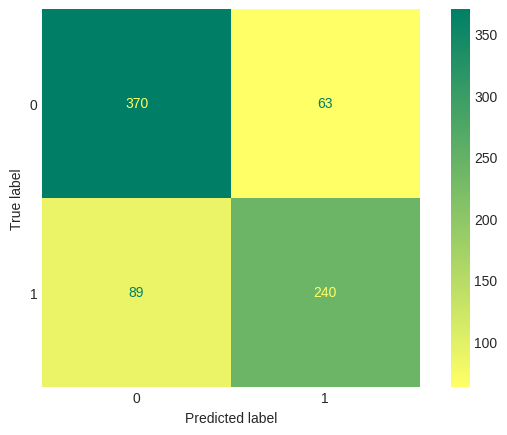

In [59]:
avaliacoes[6] = modelos[6].evaluate(X_test, y_test)
previsoes[6] = tf.squeeze(tf.round(modelos[6].predict(X_test)))
relatorios[6] = avaliar_modelo(previsoes[6], y_test)

In [60]:
relatorios[6]

{'acuracia': 0.800524934383202,
 'precisao': 0.8000465272197539,
 'revocacao': 0.800524934383202,
 'pontuacao-f1': 0.7993289558507747}

### Modelo 7: Same as model 6 but using 10% of data

#### Separar 10% dos dados

In [61]:
X_train_10 = X_train.sample(frac=0.1, random_state=SEMENTE)
y_train_10 = y_train.sample(frac=0.1, random_state=SEMENTE)

#### Clonar Modelo 6

In [62]:
modelo_nome = 'modelo_7_tfhub_use_10'

modelos[7] = clone_model(modelos[6])
modelos[7]._name = modelo_nome

modelos[7].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[7] = modelos[7].fit(x=X_train_10,
                               y=y_train_10,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Epoch 1/5
22/22 [==============================] - 3s 40ms/step - loss: 0.6693 - accuracy: 0.6540 - val_loss: 0.6491 - val_accuracy: 0.7060
Epoch 2/5
22/22 [==============================] - 0s 22ms/step - loss: 0.6044 - accuracy: 0.7781 - val_loss: 0.5965 - val_accuracy: 0.7572
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5257 - accuracy: 0.8292 - val_loss: 0.5424 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4558 - accuracy: 0.8365 - val_loss: 0.5043 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4054 - accuracy: 0.8409 - val_loss: 0.4864 - val_accuracy: 0.7730


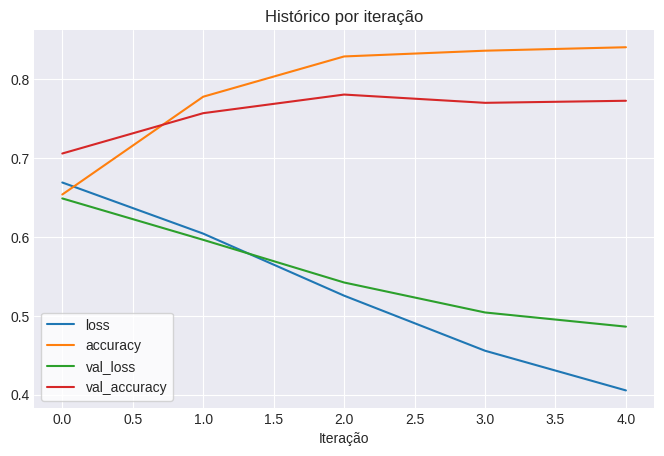

In [63]:
grafico_historico_por_iteracao(historicos[7])

24/24 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       433
           1       0.75      0.71      0.73       329

    accuracy                           0.77       762
   macro avg       0.77      0.77      0.77       762
weighted avg       0.77      0.77      0.77       762



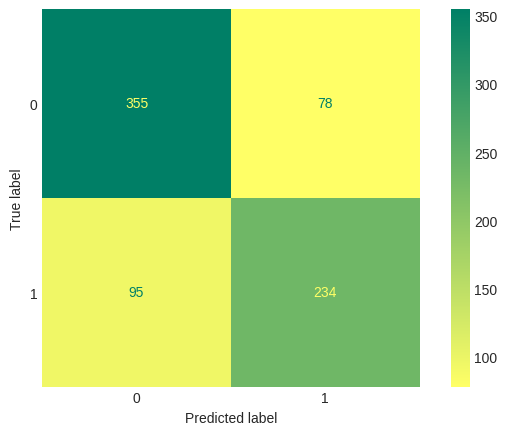

In [64]:
avaliacoes[7] = modelos[7].evaluate(X_test, y_test)
previsoes[7] = tf.squeeze(tf.round(modelos[7].predict(X_test)))
relatorios[7] = avaliar_modelo(previsoes[7], y_test)

In [65]:
relatorios[7]

{'acuracia': 0.7729658792650919,
 'precisao': 0.772098279381744,
 'revocacao': 0.7729658792650919,
 'pontuacao-f1': 0.7721407790688886}